# **NCAA Tournament Data Analysis**#
### Sifting through the Madness of College Basketball with Python

One of the main goals at the outset of this independent study was to get more experienced with Python and in particular the methods in which it's used for data science. After completing some free online tutorials on the basics of the language, I selected the March Madness competition hosted by Kaggle as the data set to practice with.  



Below, I'll go over some details of the project, my analysis to this point, and some of the struggles I've run into along the way.




### The Data

Below is a high level look at the data provided by the competition and more detailed info can be found [here](https://www.kaggle.com/c/march-machine-learning-mania-2016/data):


* ***Teams*** - list of team names and associated TeamIDs.
* ***Seasons*** - list day started and region breakdown for each season.
* ***RegularSeasonCompactResults*** - game-by-game results for 31 seasons worth of data (1985 - 2015).  Includes winning and losing teams, scores, location of game, season, etc.
* ***RegularSeasonDetailedResults*** - more in depth statistics of game-by-game results, but only avaialble for 2003 - 2015 seasons.  Things like FG, 3 pt shots, rebounds, etc.
* ***TourneyCompactResults*** - Game-by-game tournament results (1985 - 2015) with same attributes as RegularSeason file.
* ***TourneyDetailedResults*** - Game-by-game tournament results with same attributes as RegularSeasonDetailed file.
* ***TourneySeeds*** - Identifies seeds for all tournament teams (1985 - 2015).




The use of external data sources is encouraged, and my initial goal was to find or calculate coaches records on the hypothesis that in the randomness of the tournament, having a quality coach provides an advantage.   Unfortunately I wasn't able to find a source for this in time for the analysis.  

(Probably OK this year considering Tom Izzo lost in the 1st round...)

## Starting the analysis

While the online bootcamp gave me some exposure to importing/manipulating datasets like these, the competition forums on Kaggle also proved really valuable, as there are a lot of experienced users who provide basic examples to help newcomers get started.  Some of the coding below was found through these means, while other solutions were sought out using Google-Fu.  

First thing I did was import packages to be used, and some listed below were added throughout the course of my analysis when it became clear they were needed.


In [2]:
#Importing packages

import re
import numpy as np
import pandas as pd 
from pandas.stats.api import ols
from subprocess import check_output
import statsmodels.formula.api as smf
import os 
from scipy import stats, integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set(color_codes=True)

### Reading all relevant files

More will be added to this list along the way, but these were the initial ones. 

Also the SampleSubmission file was an example to be used for Round 1 of the competition, which was running your predictive model on the last 4 tournament results.  The format was a game ID concatenated from Season_Team1ID_Team2 ID and the predicted likelihood that Team1 wins the game.

In [9]:
TourneySeeds = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/TourneySeeds.csv')
SampleSubmission = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/SampleSubmission.csv')
Seasons = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/Seasons.csv')
Teams = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/Teams.csv')
TourneySlots = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/TourneySlots.csv')
TourneyDetailedResults = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/TourneyDetailedResults.csv')
TourneyCompactResults = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/TourneyCompactResults.csv')
RegularSeasonCompactResults = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/RegularSeasonCompactResults.csv')
RegularSeasonDetailedResults = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/RegularSeasonDetailedResults.csv')
team_dict = dict(zip(Teams['Team_Id'].values, Teams['Team_Name'].values))
TourneyDetailedResults['Wteam_name'] = TourneyDetailedResults['Wteam'].map(team_dict)
TourneyDetailedResults['Lteam_name'] = TourneyDetailedResults['Lteam'].map(team_dict)

#Taking a look at the file sizes, columns, etc.

print('TourneySeeds - ',TourneySeeds.shape)
print(TourneySeeds.head(5))
print()
print('RegularSeasonCompactResults - ',RegularSeasonCompactResults.shape)
print(RegularSeasonCompactResults.head(5))
print()
print('TourneyCompactResults - ',TourneyCompactResults.shape)
print(TourneyCompactResults.head(5))
print()

print('SampleSubmission - ',SampleSubmission.shape)
print(SampleSubmission.head(5))

TourneySeeds -  (2014, 3)
   Season Seed  Team
0    1985  W01  1207
1    1985  W02  1210
2    1985  W03  1228
3    1985  W04  1260
4    1985  W05  1374

RegularSeasonCompactResults -  (139920, 8)
   Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot
0    1985      20   1228      81   1328      64    N      0
1    1985      25   1106      77   1354      70    H      0
2    1985      25   1112      63   1223      56    H      0
3    1985      25   1165      70   1432      54    H      0
4    1985      25   1192      86   1447      74    H      0

TourneyCompactResults -  (1983, 8)
   Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot
0    1985     136   1116      63   1234      54    N      0
1    1985     136   1120      59   1345      58    N      0
2    1985     136   1207      68   1250      43    N      0
3    1985     136   1229      58   1425      55    N      0
4    1985     136   1242      49   1325      38    N      0

SampleSubmission -  (9112, 2)
               Id

### Extracting Seed Numbers for Each Team

As we can see above, the 'Seed' attribute in TourneySeeds also contains a letter indicating the region the team played that year.  To make calculations/numeric analysis possible, we cut out the region indicator. 

We also create a new file called game_to_predict by splitting the GameID used in the sample submission file so we can map other variables to the appropriate teams and seasons, starting with seed number here.  This will eventually help us create a submissions file.

In [10]:
#Extracting seeds for each team

TourneySeeds['SeedNum'] = TourneySeeds['Seed'].apply(lambda x: re.sub("[A-Z+a-z]", "", x, flags=re.IGNORECASE))
print(TourneySeeds.tail(5))
print()

game_to_predict = pd.concat([SampleSubmission['Id'],SampleSubmission['Id'].str.split('_', expand=True)], axis=1)
game_to_predict.rename(columns={0: 'season', 1: 'team1',2: 'team2'}, inplace=True)
game_to_predict['season'] = pd.to_numeric(game_to_predict['season'])
game_to_predict['team1'] = pd.to_numeric(game_to_predict['team1'])
game_to_predict['team2'] = pd.to_numeric(game_to_predict['team2'])
TourneySeeds['Season'] = pd.to_numeric(TourneySeeds['Season'])
TourneySeeds['Team'] = pd.to_numeric(TourneySeeds['Team'])
TourneySeeds['SeedNum'] = pd.to_numeric(TourneySeeds['SeedNum'])
game_to_predict = pd.merge(game_to_predict,TourneySeeds[['Season','Team','SeedNum']].rename(columns={'Season': 'season', 'Team': 'team1','SeedNum':'TeamSeed1'}),how='left',on=['season','team1'])
game_to_predict = pd.merge(game_to_predict,TourneySeeds[['Season','Team','SeedNum']].rename(columns={'Season': 'season', 'Team': 'team2','SeedNum':'TeamSeed2'}),how='left',on=['season','team2'])
print(game_to_predict.head(5))

      Season Seed  Team SeedNum
2009    2015  Z12  1459      12
2010    2015  Z13  1217      13
2011    2015  Z14  1209      14
2012    2015  Z15  1411      15
2013    2015  Z16  1157      16

               Id  season  team1  team2  TeamSeed1  TeamSeed2
0  2012_1104_1124    2012   1104   1124          9          3
1  2012_1104_1125    2012   1104   1125          9         14
2  2012_1104_1140    2012   1104   1140          9         14
3  2012_1104_1143    2012   1104   1143          9         12
4  2012_1104_1153    2012   1104   1153          9          6


### We then add each team's seed to the TournamentCompactResults file using a left join.

In [11]:
#Joining (compact) results with Team Seeds

compact_results = pd.merge(TourneyCompactResults, TourneySeeds[['Season','Team','SeedNum']].rename(columns={'Team': 'Wteam','SeedNum':'WSeedNum'}), how='left', on=['Season','Wteam'])
compact_results = pd.merge(compact_results, TourneySeeds[['Season','Team','SeedNum']].rename(columns={'Team': 'Lteam','SeedNum':'LSeedNum'}), how='left', on=['Season','Lteam'])
print(compact_results.head(5))

   Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot  WSeedNum  \
0    1985     136   1116      63   1234      54    N      0         9   
1    1985     136   1120      59   1345      58    N      0        11   
2    1985     136   1207      68   1250      43    N      0         1   
3    1985     136   1229      58   1425      55    N      0         9   
4    1985     136   1242      49   1325      38    N      0         3   

   LSeedNum  
0         8  
1         6  
2        16  
3         8  
4        14  


### Diverting from Forum Examples

The steps to this point were illustrated in forum examples that looked to do a simple linear regression based on difference in seed number between teams.  While I do want to include this attribute in my eventual model, I also want to factor in regular season statistics to see how much predictive value they show for tournament results.


Essentially what this entailed was summing the RegularSeasonCompactResults for each team and season combination.  I attempted to do this using the Groupby function in Pandas, and while it would aggregate the data based on the fields I indicated, it also changed it to another type that I wasn't able to revert back to a dataframe.  I was up against deadlines for the tournmanent and decided to do the calculations quick in Excel instead, creating two new attributes for win/loss margins, counts of wins/losses by location (Home, Away, or Neut), then splitting these into seperate files for winning categories and losing categories.

Now that I had these, I could begin to put my file together.


In [12]:
#Merging new files WinStats and LossStats (aggregated data from RegSeasonCompactResults)

WinStats = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/WinStats.csv')
LossStats = pd.read_csv('C:/Users/Nate/Documents/Data_Study/March_Madness/LossStats.csv')

RegSeason = pd.merge(WinStats,LossStats[['Season','Team_ID','Away_L', 'Home_L', 'Neut_L', 'Lscore','Loss_Margin']],how='left',on=['Season','Team_ID'])

#Replacing NAN with zeros so calculations work
RegSeason = RegSeason.fillna(0)

#Adding additional attributes to get winning percentage
RegSeason['Total_L']=RegSeason['Away_L']+RegSeason['Home_L']+RegSeason['Neut_L']
RegSeason['Total_W']=RegSeason['Away_W']+RegSeason['Home_W']+RegSeason['Neut_W']
RegSeason['Total_G']=RegSeason['Total_W']+RegSeason['Total_L']
RegSeason['Win_Pct']=RegSeason['Total_W']/RegSeason['Total_G']
RegSeason['Total_Pts']=RegSeason['Wscore']+RegSeason['Lscore']

"""
Realized after first model that number of games played varies from team to team
While more games played could be a sign of success (ie made it further in conf tournament), things like total pts 
and total margin of victory would be better served as per game averages
"""
print('Total Game Statistics ')
print(RegSeason['Total_G'].describe())
print()

RegSeason['Avg_Pts_Per'] = RegSeason['Total_Pts']/RegSeason['Total_G']
RegSeason['Avg_Win_Margin'] = RegSeason['Win_Margin']/RegSeason['Total_W']
RegSeason['Avg_Loss_Margin'] = RegSeason['Loss_Margin']/RegSeason['Total_L']

print('RegSeason - ',RegSeason.shape)
print(RegSeason.head(5))

Total Game Statistics 
count    9821.000000
mean       28.457591
std         2.513580
min        10.000000
25%        27.000000
50%        28.000000
75%        30.000000
max        36.000000
Name: Total_G, dtype: float64

RegSeason -  (9821, 20)
   Season  Team_ID  Away_W  Home_W  Neut_W  Total_W  Wscore  Win_Margin  \
0    1985     1102       3       2       0        5     355          50   
1    1985     1103       2       7       0        9     632          68   
2    1985     1104       5      15       1       21    1514         277   
3    1985     1106       1       8       1       10     751          95   
4    1985     1108       8       8       3       19    1631         263   

   Away_L  Home_L  Neut_L  Lscore  Loss_Margin  Total_L  Total_G   Win_Pct  \
0       9       8       2    1159         -189       19       24  0.208333   
1       8       6       0     772         -138       14       23  0.391304   
2       6       1       2     541          -43        9       30  0.7

### Merging RegSeason with TournamentResults

My next step was to merge this new file with the compact_results file created earlier to map the regular season statistics to each winning and losing team for every tournament game.

In [13]:
#first want to create a Game_ID column in compact_results by changing relevant attributes to strings and concatenating

compact_results['Wteam'] = compact_results['Wteam'].astype(str)
compact_results['Lteam'] = compact_results['Lteam'].astype(str)
compact_results['Season'] = compact_results['Season'].astype(str)

compact_results['Game_ID'] = compact_results['Season'] + '_' + compact_results['Wteam'] + '_' + compact_results['Lteam']
print(compact_results.head(5))

  Season  Daynum Wteam  Wscore Lteam  Lscore Wloc  Numot  WSeedNum  LSeedNum  \
0   1985     136  1116      63  1234      54    N      0         9         8   
1   1985     136  1120      59  1345      58    N      0        11         6   
2   1985     136  1207      68  1250      43    N      0         1        16   
3   1985     136  1229      58  1425      55    N      0         9         8   
4   1985     136  1242      49  1325      38    N      0         3        14   

          Game_ID  
0  1985_1116_1234  
1  1985_1120_1345  
2  1985_1207_1250  
3  1985_1229_1425  
4  1985_1242_1325  


In [11]:
#Have to convert variables in RegSeason to same type so the merge will work
RegSeason['Team_ID'] = RegSeason['Team_ID'].astype(str)
RegSeason['Season'] = RegSeason['Season'].astype(str)

#seperating the winners and losers from compact_results to merge with regular season stats based on team_ID and season
set3 = compact_results[['Season','Wteam','Wscore','WSeedNum','Game_ID']].rename(columns={'Wteam':'Team_ID'})
set3 = pd.merge(set3,RegSeason[['Season','Team_ID','Away_L', 'Home_L', 'Neut_L','Avg_Loss_Margin', 'Away_W', 'Home_W', 'Neut_W', 'Total_W','Avg_Win_Margin','Win_Pct', 'Avg_Pts_Per']],how='left',on=['Season','Team_ID'])

set4 = compact_results[['Season','Lteam','Lscore','LSeedNum','Game_ID']].rename(columns={'Lteam':'Team_ID'})
set4 = pd.merge(set4,RegSeason[['Season','Team_ID','Away_L', 'Home_L', 'Neut_L','Avg_Loss_Margin', 'Away_W','Home_W', 'Neut_W', 'Total_W','Avg_Win_Margin', 'Win_Pct', 'Avg_Pts_Per']],how='left',on=['Season','Team_ID'])

print('Set3 ',set3.shape)
print('Set4 ',set4.shape)


Set3  (1983, 16)
Set4  (1983, 16)


### EDA: Comparing RegSeason Statistics for Tournament Winners and Losers

In [9]:
#Looking at means for attributes of interest to see how they differ across teams with tourney wins and losses.  

print('RegSeason Means for Teams with Tournament Wins:')
print(set3[['WSeedNum','Away_L', 'Home_L','Neut_L', 'Avg_Loss_Margin', 'Away_W', 'Home_W', 'Neut_W', 'Total_W','Avg_Win_Margin', 'Win_Pct', 'Avg_Pts_Per']].mean())
print()
print('Avg RegSeason Means for Teams with Tournament losses:')
print(set4[['LSeedNum','Away_L', 'Home_L','Neut_L', 'Avg_Loss_Margin', 'Away_W', 'Home_W', 'Neut_W', 'Total_W','Avg_Win_Margin', 'Win_Pct', 'Avg_Pts_Per']].mean())


RegSeason Means for Teams with Tournament Wins:
WSeedNum            4.898134
Away_L              4.012103
Home_L              1.568835
Neut_L              1.249117
Avg_Loss_Margin    -8.315957
Away_W              6.961170
Home_W             13.428139
Neut_W              3.517902
Total_W            23.907211
Avg_Win_Margin     15.972721
Win_Pct             0.776651
Avg_Pts_Per        77.538592
dtype: float64

Avg RegSeason Means for Teams with Tournament losses:
LSeedNum            8.692890
Away_L              5.114977
Home_L              1.944024
Neut_L              1.182047
Avg_Loss_Margin    -9.254753
Away_W              6.627837
Home_W             12.319718
Neut_W              2.912758
Total_W            21.860313
Avg_Win_Margin     14.181754
Win_Pct             0.725421
Avg_Pts_Per        75.116365
dtype: float64


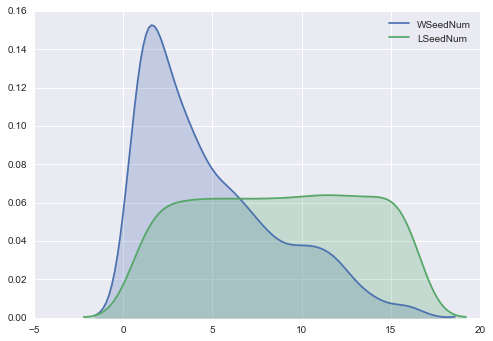

In [10]:
#Plotting Distributions for each variable, with Blue representing winners and Green losers

sns.kdeplot(set3['WSeedNum'], shade=True);
sns.kdeplot(set4['LSeedNum'], shade=True);

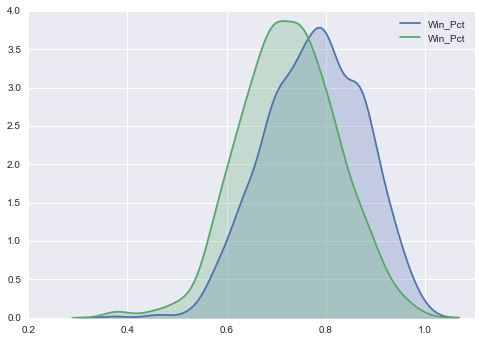

In [11]:
sns.kdeplot(set3['Win_Pct'], shade=True);
sns.kdeplot(set4['Win_Pct'], shade=True);

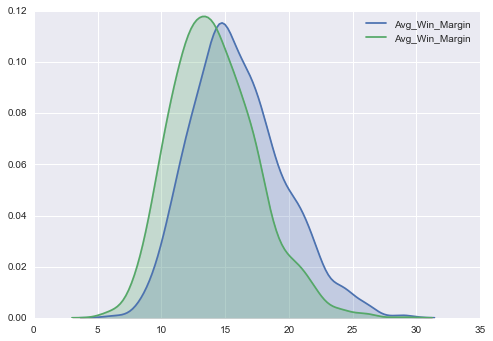

In [12]:
sns.kdeplot(set3['Avg_Win_Margin'], shade=True);
sns.kdeplot(set4['Avg_Win_Margin'], shade=True);

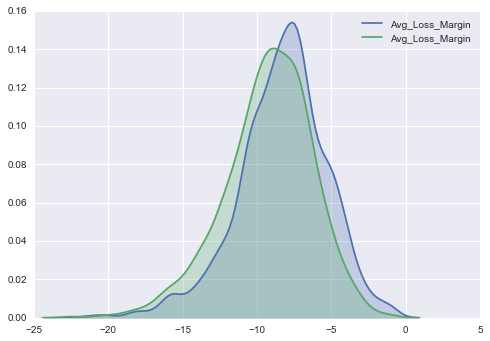

In [13]:
sns.kdeplot(set3['Avg_Loss_Margin'], shade=True);
sns.kdeplot(set4['Avg_Loss_Margin'], shade=True);

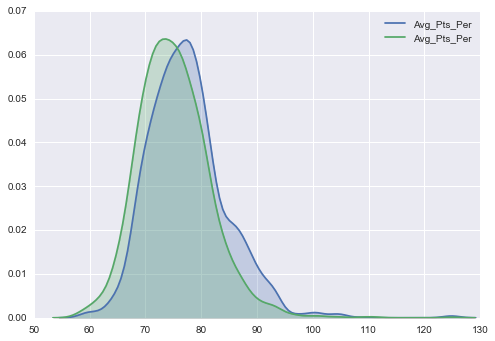

In [14]:
sns.kdeplot(set3['Avg_Pts_Per'], shade=True);
sns.kdeplot(set4['Avg_Pts_Per'], shade=True);

### Some things that stand out...

* The means for each attribute are more favorable for winning tournament teams, however the margin of difference in most cases is very small when averaged.  The only attribute with a noticeable difference is ***Seed Number***, which is to be expected considering that lower-seeded teams are by definition given the advantage of playing teams with less impressive records/stats than them.
* Consideration for averages for this data: there are only 32 unique teams that will record a win (the recently added play-in games not considered).  Of these, 31 will also record a tournament loss that same year with only the champion going undefeated.  So if a team wins one game and loses the next (16 cases each year), the regular season stats essentially cancel each other out, while those teams that go on to win multiple games should have more weight on the difference between winning and losing teams.
* The plots for each attribute also favor winning teams in the way we'd expect, and the ***Seed Number*** distributions are the only ones that don't appear to follow a Guassian distribution (or close to).  This shows us that teams seeded 1-3 win tournament games between 3-15x more often than they lose, and teams ranked as 6 or 7 seeds win roughly just as often as they lose.  
* The other two distribution exceptions are ***Avg_Win_Margin*** (slightly skewed right) and *** Avg_Loss_Margin***  (skewed left).
* One thing that is interesting is that for winning teams, there is a slight abrupt drop or jagged corner for each attribute, most considerably in *** Win_Pct***.  This could indicate that it's fairly common for winning teams to have a high level of performance, but their is a threshold somewhere that significantly fewer teams reach.


At this point I continued with my plan of creating a linear regression comparing the difference in RegSeason attributes for each matchup for the sake of getting my first working model in Python, but the small difference in these categories had me concerned about their predictive value.


### Every win for one team is a loss for another

Now I have two seperate dataframes for winners and losers of tournament games merged with regular season stats, next I need to create the binary variable of Team1Win.  Essentially I need two records for every tourney game played, one with the winning team first + Team1Win = 1, and one with losing team first + Team1Win = 0.

In [120]:
#Renaming columns so that when I merge them together, team 1 and team 2 stats are unique.  Sets 3 and 4 are for winners set to Team1 (Team1Win = 1).  
#Sets 5 and 6 are for losers set to Team1 (Team1Win = 0).  This was tedious and my guess is there is a prettier way to do this in Python.

set3 = set3.rename(columns={'Team_ID':'Team1','Wscore':'Team1_Score','WSeedNum':'Team1Seed'})
set4 = set4.rename(columns={'Team_ID':'Team2', 'Lscore':'Team2_Score','LSeedNum':'Team2Seed','Away_L':'Away_L2','Home_L':'Home_L2','Neut_L':'Neut_L2','Avg_Loss_Margin':'Avg_Loss_Margin2', 'Away_W':'Away_W2', 'Home_W':'Home_W2', 'Neut_W':'Neut_W2', 'Total_W':'Total_W2','Avg_Win_Margin':'Avg_Win_Margin2', 'Win_Pct':'Win_Pct2', 'Avg_Pts_Per':'Avg_Pts_Per2'})

set5 = set4.rename(columns={'Team2':'Team1', 'Team2_Score':'Team1_Score','Team2Seed':'Team1Seed','Away_L2':'Away_L','Home_L2':'Home_L','Neut_L2':'Neut_L','Avg_Loss_Margin2':'Avg_Loss_Margin', 'Away_W2':'Away_W', 'Home_W2':'Home_W', 'Neut_W2':'Neut_W', 'Total_W2':'Total_W','Avg_Win_Margin2':'Avg_Win_Margin', 'Win_Pct2':'Win_Pct', 'Avg_Pts_Per2':'Avg_Pts_Per'})
set6 = set3.rename(columns={'Team1':'Team2', 'Team1_Score':'Team2_Score','Team1Seed':'Team2Seed','Away_L':'Away_L2','Home_L':'Home_L2','Neut_L':'Neut_L2','Avg_Loss_Margin':'Avg_Loss_Margin2', 'Away_W':'Away_W2', 'Home_W':'Home_W2', 'Neut_W':'Neut_W2', 'Total_W':'Total_W2','Avg_Win_Margin':'Avg_Win_Margin2', 'Win_Pct':'Win_Pct2', 'Avg_Pts_Per':'Avg_Pts_Per2'})

#Setting Team1Win.  This will be the target variable for our regression.

winnerfirst_set = pd.merge(set3,set4,how='left',on=['Game_ID'])
winnerfirst_set['Team1Win']=1

loserfirst_set = pd.merge(set5,set6,how='left',on=['Game_ID'])
loserfirst_set['Team1Win']=0

#combining the 2 files into one and setting these variables to numeric.  

complete_set = pd.concat([winnerfirst_set,loserfirst_set],ignore_index=True)
complete_set['Team1Seed'] = pd.to_numeric(complete_set['Team1Seed'])
complete_set['Team2Seed'] = pd.to_numeric(complete_set['Team2Seed'])
complete_set['Team1Win'] = pd.to_numeric(complete_set['Team1Win'])

#dropping duplicated season attribute
complete_set = complete_set.drop(['Season_y'],axis=1)
complete_set = complete_set.rename(columns={'Season_x':'Season'})


print('complete_set', complete_set.shape)
print(complete_set.columns)
print()


complete_set (3966, 31)
Index(['Season', 'Team1', 'Team1_Score', 'Team1Seed', 'Game_ID', 'Away_L',
       'Home_L', 'Neut_L', 'Avg_Loss_Margin', 'Away_W', 'Home_W', 'Neut_W',
       'Total_W', 'Avg_Win_Margin', 'Win_Pct', 'Avg_Pts_Per', 'Team2',
       'Team2_Score', 'Team2Seed', 'Away_L2', 'Home_L2', 'Neut_L2',
       'Avg_Loss_Margin2', 'Away_W2', 'Home_W2', 'Neut_W2', 'Total_W2',
       'Avg_Win_Margin2', 'Win_Pct2', 'Avg_Pts_Per2', 'Team1Win'],
      dtype='object')



In [16]:
#found there were still a few blanks in avg_loss_margin for teams that never lost, so filling those with zero so the below calculations work
complete_set = complete_set.fillna(0)

#creating attributes for differences between 1st and 2nd team, then making a smaller dataframe with just the relevant variables to work with

complete_set['Seed_Dif']=complete_set['Team1Seed']-complete_set['Team2Seed']
complete_set['Win_Pct_Dif']=complete_set['Win_Pct']-complete_set['Win_Pct2']
complete_set['Total_W_Dif']=complete_set['Total_W']-complete_set['Total_W2']
complete_set['Avg_Win_Margin_Dif']=complete_set['Avg_Win_Margin']-complete_set['Avg_Win_Margin2']
complete_set['Avg_Loss_Margin_Dif']=complete_set['Avg_Loss_Margin']-complete_set['Avg_Loss_Margin2']
complete_set['Avg_Pts_Per_Dif']=complete_set['Avg_Pts_Per']-complete_set['Avg_Pts_Per2']

RegressionSet = complete_set[['Game_ID','Team1','Team2','Seed_Dif','Win_Pct_Dif','Avg_Win_Margin_Dif','Avg_Loss_Margin_Dif','Avg_Pts_Per_Dif','Team1Win']]

print(RegressionSet.head(5))
print()
print(RegressionSet.tail(5))


          Game_ID Team1 Team2  Seed_Dif  Win_Pct_Dif  Avg_Win_Margin_Dif  \
0  1985_1116_1234  1116  1234         1    -0.030303           -8.116667   
1  1985_1120_1345  1120  1345         5    -0.059310           -0.696078   
2  1985_1207_1250  1207  1250       -15     0.546616           11.040000   
3  1985_1229_1425  1229  1425         1     0.062169            1.928947   
4  1985_1242_1325  1242  1325       -11     0.025926            1.243478   

   Avg_Loss_Margin_Dif  Avg_Pts_Per_Dif  Team1Win  
0            -2.583333        -4.400000         1  
1             5.113636         1.224828         1  
2             9.333333         9.982120         1  
3            -1.317460         3.199735         1  
4            -1.285714         8.477778         1  

             Game_ID Team1 Team2  Seed_Dif  Win_Pct_Dif  Avg_Win_Margin_Dif  \
3961  2015_1181_1211  1211  1181         1     0.060606           -0.132369   
3962  2015_1277_1257  1257  1277        -3     0.073529            0.014

### Creating a predictive model based on these differences

The forum example I had found had looked at only Seed_Dif, so I want to use the other comparison attributes as my independents first, then add Seed_Dif after.

In [17]:
lm_1 = smf.ols(formula='Team1Win ~ Win_Pct_Dif + Avg_Win_Margin_Dif + Avg_Loss_Margin_Dif + Avg_Pts_Per_Dif', data=RegressionSet).fit()

lm_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Team1Win   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     199.4
Date:                Wed, 27 Apr 2016   Prob (F-statistic):          5.63e-156
Time:                        10:48:28   Log-Likelihood:                -2514.7
No. Observations:                3966   AIC:                             5039.
Df Residuals:                    3961   BIC:                             5071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.5000      0.007     68.982      0.000         0.486     0.514
Win_Pct_Dif             0.6374      0.057     11.161      0.000         0.525     0.749
Avg_Win_Margin_Dif      0.0195      0.002     10.647      0.000         0.016     0.023
Avg_Loss_Margin_Dif     0.0102      0.002      5.788      0.000         0.007     0.014
Avg_Pts_Per_Dif         0.0026      0.001      2.446      0.014         0.001     0.005
==============================================================================
Omnibus:                        1.001   Durbin-Watson:                   0.339
Prob(Omnibus):                  0.606   Jarque-Bera (JB):              345.870
Skew:                           0.000   Prob(JB):                     7.86e-76
Kurtosis:                       1.553   Cond. No.                         75.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now let's look at Seed_Dif alone (simple Linear Regression)

In [18]:
lm_SeedOnly =ols(y=RegressionSet['Team1Win'],x=RegressionSet['Seed_Dif'])
print(lm_SeedOnly)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         3966
Number of Degrees of Freedom:   2

R-squared:         0.2525
Adj R-squared:     0.2523

Rmse:              0.4324

F-stat (1, 3964):  1339.2037, p-value:     0.0000

Degrees of Freedom: model 1, resid 3964

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0333     0.0009     -36.60     0.0000    -0.0351    -0.0315
     intercept     0.5000     0.0069      72.82     0.0000     0.4865     0.5135
---------------------------------End of Summary---------------------------------



### Combining the two

In [19]:
lm_combo = smf.ols(formula='Team1Win ~ Seed_Dif + Win_Pct_Dif + Avg_Win_Margin_Dif + Avg_Loss_Margin_Dif + Avg_Pts_Per_Dif', data=RegressionSet).fit()
lm_combo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Team1Win   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     288.5
Date:                Wed, 27 Apr 2016   Prob (F-statistic):          7.43e-264
Time:                        10:48:47   Log-Likelihood:                -2262.6
No. Observations:                3966   AIC:                             4537.
Df Residuals:                    3960   BIC:                             4575.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.5000      0.007     73.501      0.000         0.487     0.513
Seed_Dif               -0.0282      0.001    -23.174      0.000        -0.031    -0.026
Win_Pct_Dif            -0.0134      0.061     -0.222      0.824        -0.132     0.105
Avg_Win_Margin_Dif      0.0092      0.002      5.170      0.000         0.006     0.013
Avg_Loss_Margin_Dif     0.0061      0.002      3.650      0.000         0.003     0.009
Avg_Pts_Per_Dif         0.0020      0.001      2.025      0.043      6.37e-05     0.004
==============================================================================
Omnibus:                     1449.984   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.485
Skew:                          -0.000   Prob(JB):                     5.86e-43
Kurtosis:                       1.915   Cond. No.                         94.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting the Results

All three regressions came back less than impressive in terms of our dependent variables explaining the variation in our target (Team1Win).  Adding our RegSeason comparison stats to Seed_Dif only increased our adj. R-squared by 0.0133 to a not so large total of 0.266.  Also this model returns a very large P-value for Win_Pct_Dif making it statistaically insignificant (Avg_Pts_Per also near our cut off of 0.05).  

These results sync up with what we saw in EDA, as Seed-Dif is far and away the most relevant of these attributes.  One potential explanation for this is that a panel of experts assign these seeds by already looking at all of the RegSeason stats that I did while also including factors not included in mine (like the measurement of RPI to indicate strength of schedule).  The difference between RegSeason's adj. R-squared of 0.167 and the 0.2523 of Seed_Dif could be explained by some of these missing attributes.

I have other ideas about looking at weighting statistics in late season games higher than earlier ones, building a model to predict total number of tournament wins (and an eventual winner), and exploring the detailed regular statistics to predict points scored in the tournament.    

At this point however I was up against a deadline and not really concerned with winning, so was going to remove the unnecessary variables and create a submissions file using the game_to_predict df we made in the beginning.  I proved unsuccesful in meeting the deadline because I couldn't get my csv created, but below are the steps I went through to eventually create one (even though it was past the deadline by the time it was worked out).

In [21]:
lm_combo = smf.ols(formula='Team1Win ~ Seed_Dif + Avg_Win_Margin_Dif + Avg_Loss_Margin_Dif + Avg_Pts_Per_Dif', data=RegressionSet).fit()
lm_combo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Team1Win   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     360.7
Date:                Wed, 27 Apr 2016   Prob (F-statistic):          3.77e-265
Time:                        10:51:08   Log-Likelihood:                -2262.6
No. Observations:                3966   AIC:                             4535.
Df Residuals:                    3961   BIC:                             4567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.5000      0.007     73.510      0.000         0.487     0.513
Seed_Dif               -0.0281      0.001    -26.050      0.000        -0.030    -0.026
Avg_Win_Margin_Dif      0.0092      0.002      5.169      0.000         0.006     0.013
Avg_Loss_Margin_Dif     0.0061      0.002      3.654      0.000         0.003     0.009
Avg_Pts_Per_Dif         0.0020      0.001      2.024      0.043      6.14e-05     0.004
==============================================================================
Omnibus:                     1459.671   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.873
Skew:                          -0.000   Prob(JB):                     4.83e-43
Kurtosis:                       1.914   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Setting a Current Working Directory

Found out about setting CWD when I was having trouble writing my own csv file, which wouldn't work until a CWD was set. This also can make syntax for reading files easier but I had already read my files by this point.

In [5]:
#Setting a current working directory so I can print csv files again

path = 'C:/Users/Nate/Documents/Data_Study'

os.chdir(path)
print('The current working directory is', os.getcwd())


The current working directory is C:\Users\Nate\Documents\Data_Study


### Do teams entering the tournament on a hot streak perform better?

Given the relatively low predictive value found for regular season stats, I next wanted to see if giving more weight to a team's performance later in the season would change this. To find out, I will get similar regular season statistics, but use ***Daynum*** attribute to identify each game in the season, and then calculate new variables to give each stat of interest a value correlated to game it's from. 


In [115]:
print(RegularSeasonCompactResults.columns)

Index(['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore', 'Wloc',
       'Numot'],
      dtype='object')


In [58]:

RegSeasonWeighted = RegularSeasonCompactResults[['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore']]

RegSeasonWeighted['Win_Margin']=RegSeasonWeighted['Wscore']-RegSeasonWeighted['Lscore']
RegSeasonWeighted['Loss_Margin']=RegSeasonWeighted['Win_Margin']*-1

#Changing to string so I can concatenate Season and TeamID later
RegSeasonWeighted['Wteam'] = RegSeasonWeighted['Wteam'].astype(str)
RegSeasonWeighted['Lteam'] = RegSeasonWeighted['Lteam'].astype(str)
RegSeasonWeighted['Season'] = RegSeasonWeighted['Season'].astype(str)

#splitting wins and losses so I can add dummy variables
RegSeasonWeighted_Wins = RegSeasonWeighted[['Season', 'Daynum', 'Wteam', 'Wscore', 'Win_Margin']]
RegSeasonWeighted_Wins['Loss_Margin']=0
RegSeasonWeighted_Wins['Loss_Dummy']=0
RegSeasonWeighted_Wins['Win_Dummy']=1

RegSeasonWeighted_Losses = RegSeasonWeighted[['Season', 'Daynum', 'Lteam', 'Lscore', 'Loss_Margin']]
RegSeasonWeighted_Losses['Win_Margin']=0
RegSeasonWeighted_Losses['Loss_Dummy']=1
RegSeasonWeighted_Losses['Win_Dummy']=0

#Creating Season_TeamID so I can try and put in a loop 
RegSeasonWeighted_Wins['Season_TeamID'] = RegSeasonWeighted_Wins['Season'] + '_' + RegSeasonWeighted_Wins['Wteam']
RegSeasonWeighted_Losses['Season_TeamID'] = RegSeasonWeighted_Losses['Season'] + '_' + RegSeasonWeighted_Losses['Lteam']

#Combining the two dataframes
RegSeasonWeighted_Wins = RegSeasonWeighted_Wins.rename(columns={'Wteam':'Team_ID','Wscore':'Points'})
RegSeasonWeighted_Losses = RegSeasonWeighted_Losses.rename(columns={'Lteam':'Team_ID','Lscore':'Points'})

RegSeasonWeighted_set = pd.concat([RegSeasonWeighted_Wins,RegSeasonWeighted_Losses],ignore_index=True)
RegSeasonWeighted_set = RegSeasonWeighted_set[['Season','Daynum','Team_ID','Season_TeamID','Points','Win_Dummy','Win_Margin','Loss_Dummy','Loss_Margin']]


print(RegSeasonWeighted_set.head(5))
print(RegSeasonWeighted_set.tail(5))


  Season  Daynum Team_ID Season_TeamID  Points  Win_Dummy  Win_Margin  \
0   1985      20    1228     1985_1228      81          1          17   
1   1985      25    1106     1985_1106      77          1           7   
2   1985      25    1112     1985_1112      63          1           7   
3   1985      25    1165     1985_1165      70          1          16   
4   1985      25    1192     1985_1192      86          1          12   

   Loss_Dummy  Loss_Margin  
0           0            0  
1           0            0  
2           0            0  
3           0            0  
4           0            0  
       Season  Daynum Team_ID Season_TeamID  Points  Win_Dummy  Win_Margin  \
279835   2015     132    1204     2015_1204      36          0           0   
279836   2015     132    1116     2015_1116      63          0           0   
279837   2015     132    1163     2015_1163      54          0           0   
279838   2015     132    1173     2015_1173      65          0           0 

In [59]:
#Sorting by Season, Team_ID, and Daynum to try and create a variable that shows which game number it is (which I will then use to calculate weights)

RegSeasonWeighted_set['Team_ID'] = pd.to_numeric(RegSeasonWeighted_set['Team_ID'])
RegSeasonWeighted_set['Season'] = pd.to_numeric(RegSeasonWeighted_set['Season'])

RegSeasonWeighted_set.sort_values(by=['Season','Team_ID','Daynum'], ascending=[True,False,True], inplace=True)

print(RegSeasonWeighted_set.head(20))

        Season  Daynum  Team_ID Season_TeamID  Points  Win_Dummy  Win_Margin  \
82        1985      28     1464     1985_1464      71          1          13   
173       1985      32     1464     1985_1464      81          1          26   
259       1985      33     1464     1985_1464      70          1          13   
140264    1985      37     1464     1985_1464      73          0           0   
140412    1985      40     1464     1985_1464      49          0           0   
689       1985      47     1464     1985_1464      74          1           1   
140648    1985      50     1464     1985_1464      56          0           0   
140675    1985      52     1464     1985_1464      69          0           0   
140743    1985      54     1464     1985_1464      70          0           0   
929       1985      59     1464     1985_1464      70          1           7   
1300      1985      68     1464     1985_1464      75          1          14   
141385    1985      75     1464     1985

### Calcuting Weighted Statistics Using 'Game_Count'

At this point I wanted to create a ***Game_Count*** column that would indicate what game number it was in the season for each unique Season_TeamID.  I knew I could very easily do this with an IF statement in Excel, but in an effort to keep everything Python focused I tried using **for and while loops**. This proved unsuccesful, and the closest I came was to a solution was importing a package called arcpy and using their AutoIncrement function.  But again this proved unsuccesful, as it returned 'Module arcpy does not exist', which I believe may have to do with the version of Python I'm using (64-bit might not be compatible).  Alas after a few hours I decided to export to csv and do a simple IF statement.


Once I created GameCount, I used this number to determine a "Weight_Factor" for each record that will be used to create new calculated fields for each variable of interest.  The average number of games played per season is 27, so I've decided (arbitrarily so) to split seasons into 3 sections and apply a different weight factor to each.  The first third (games 1-9) have a weight factor of **0.7**, the second third has a weight factor of **0.85**, and the third segment (all games past 18) have a weight_factor of **1**. This should make it so that stats from later in the season will be of greater consequence (for both winning and losing).

In [69]:
#creating csv output for dataframe
RegSeasonWeighted_set.to_csv('RegSeasonWeighted_set.csv',index=False)

In [6]:
#reading new file and creating weighted stats
RegSeasonWeighted_set2 = pd.read_csv('RegSeasonWeighted_set_v3.csv')

RegSeasonWeighted_set2['Points_Weight'] = RegSeasonWeighted_set2['Points']*RegSeasonWeighted_set2['Weight_Factor']
RegSeasonWeighted_set2['Wins_Weight'] = RegSeasonWeighted_set2['Win_Dummy']*RegSeasonWeighted_set2['Weight_Factor']
RegSeasonWeighted_set2['Win_Margin_Weight'] = RegSeasonWeighted_set2['Win_Margin']*RegSeasonWeighted_set2['Weight_Factor']
RegSeasonWeighted_set2['Losses_Weight'] = RegSeasonWeighted_set2['Loss_Dummy']*RegSeasonWeighted_set2['Weight_Factor']
RegSeasonWeighted_set2['Loss_Margin_Weight'] = RegSeasonWeighted_set2['Loss_Margin']*RegSeasonWeighted_set2['Weight_Factor']

print(RegSeasonWeighted_set2.head(5))

   Season  Daynum  Team_ID Season_TeamID  Points  Win_Dummy  Win_Margin  \
0    1985      28     1464     1985_1464      71          1          13   
1    1985      32     1464     1985_1464      81          1          26   
2    1985      33     1464     1985_1464      70          1          13   
3    1985      37     1464     1985_1464      73          0           0   
4    1985      40     1464     1985_1464      49          0           0   

   Loss_Dummy  Loss_Margin  Game_Count  Weight_Factor  Points_Weight  \
0           0            0           1            0.7           49.7   
1           0            0           2            0.7           56.7   
2           0            0           3            0.7           49.0   
3           1          -30           4            0.7           51.1   
4           1          -18           5            0.7           34.3   

   Wins_Weight  Win_Margin_Weight  Losses_Weight  Loss_Margin_Weight  
0          0.7                9.1            

### I cracked the Groupby function!

Previously I couldn't figure out how to return it to a dataframe, but turns out it's much simpler than I thought.  Don't let the one line of code fool you though, this is my greatest Python accomplishment to date :)  Going to sum the appropriate values, turn them into averages (like we did with the unweighted statistics), and create a new df that takes out unused attributes.

In [7]:
#Summing these values using groupby function again, except THIS TIME I know how to change it back to a dataframe.

g1 = RegSeasonWeighted_set2.groupby(["Season", "Team_ID"], as_index=False).sum()

g1['Total_Games']=g1['Win_Dummy']+g1['Loss_Dummy']
g1['Win_Pct']=g1['Wins_Weight']/g1['Weight_Factor']      #Abbreviated version of win_pct, 'win points earned/total win points possible'
g1['Avg_Win_Margin']=g1['Win_Margin_Weight']/g1['Win_Dummy']
g1['Avg_Loss_Margin']=g1['Loss_Margin_Weight']/g1['Loss_Dummy']
g1['Avg_Pts_Per']=g1['Points_Weight']/g1['Total_Games']

g1 = g1.fillna(0)

RegSeasonWeighted_final = g1[['Season','Team_ID','Total_Games','Win_Dummy','Loss_Dummy','Win_Pct','Avg_Win_Margin','Avg_Loss_Margin','Avg_Pts_Per']]
print(RegSeasonWeighted_final.head(5))

   Season  Team_ID  Total_Games  Win_Dummy  Loss_Dummy   Win_Pct  \
0    1985     1102           24          5          19  0.220551   
1    1985     1103           23          9          14  0.403694   
2    1985     1104           30         21           9  0.687861   
3    1985     1106           24         10          14  0.426065   
4    1985     1108           25         19           6  0.778043   

   Avg_Win_Margin  Avg_Loss_Margin  Avg_Pts_Per  
0        7.600000        -7.784211    52.389583  
1        6.355556        -8.067857    50.726087  
2       11.104762        -4.227778    58.735000  
3        7.610000       -10.703571    59.806250  
4       11.371053        -8.566667    69.326000  


In [14]:
#Have to convert variables in RegSeason to same type so the merge will work
RegSeasonWeighted_final['Team_ID'] = RegSeasonWeighted_final['Team_ID'].astype(str)
RegSeasonWeighted_final['Season'] = RegSeasonWeighted_final['Season'].astype(str)

#seperating the winners and losers from compact_results to merge with regular season stats based on team_ID and season
set7 = compact_results[['Season','Wteam','WSeedNum','Game_ID']].rename(columns={'Wteam':'Team_ID'})
set7 = pd.merge(set7,RegSeasonWeighted_final[['Season','Team_ID','Win_Pct','Avg_Win_Margin','Avg_Loss_Margin','Avg_Pts_Per']],how='left',on=['Season','Team_ID'])

set8 = compact_results[['Season','Lteam','LSeedNum','Game_ID']].rename(columns={'Lteam':'Team_ID'})
set8 = pd.merge(set8,RegSeasonWeighted_final[['Season','Team_ID','Win_Pct','Avg_Win_Margin','Avg_Loss_Margin','Avg_Pts_Per']],how='left',on=['Season','Team_ID'])

#Now going to look at same EDA as we did for first dataset

print('RegSeason Means for Teams with Tournament Wins:')
print(set7[['WSeedNum','Win_Pct','Avg_Win_Margin','Avg_Loss_Margin','Avg_Pts_Per']].mean())
print()
print('Avg RegSeason Means for Teams with Tournament losses:')
print(set8[['LSeedNum','Win_Pct','Avg_Win_Margin','Avg_Loss_Margin','Avg_Pts_Per']].mean())

C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


RegSeason Means for Teams with Tournament Wins:
WSeedNum            4.898134
Win_Pct             0.772011
Avg_Win_Margin     13.431123
Avg_Loss_Margin    -7.315108
Avg_Pts_Per        67.017626
dtype: float64

Avg RegSeason Means for Teams with Tournament losses:
LSeedNum            8.692890
Win_Pct             0.725533
Avg_Win_Margin     12.036154
Avg_Loss_Margin    -7.908883
Avg_Pts_Per        64.829823
dtype: float64


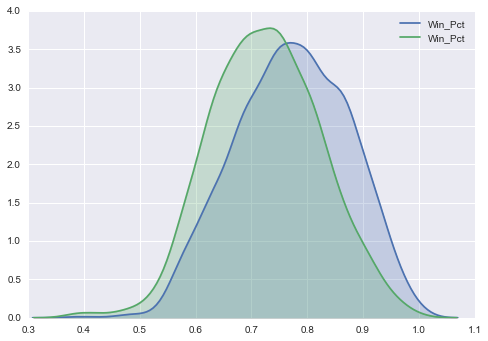

In [26]:
#Plotting Distributions for each variable, with Blue representing winners and Green losers

sns.kdeplot(set7['Win_Pct'], shade=True);
sns.kdeplot(set8['Win_Pct'], shade=True);

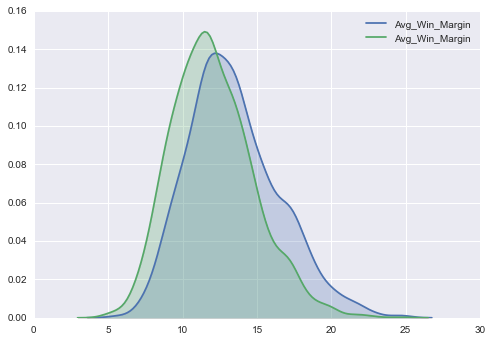

In [15]:
#Avg_Loss_Margin is just the inverse of this graph

sns.kdeplot(set7['Avg_Win_Margin'], shade=True);
sns.kdeplot(set8['Avg_Win_Margin'], shade=True);

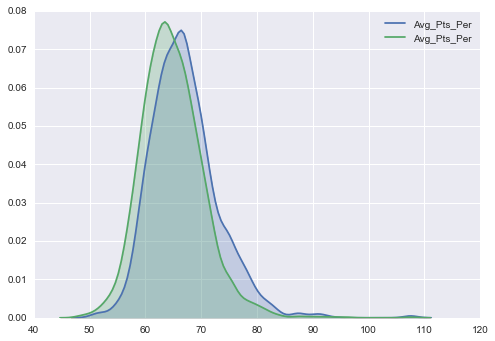

In [28]:
sns.kdeplot(set7['Avg_Pts_Per'], shade=True);
sns.kdeplot(set8['Avg_Pts_Per'], shade=True);

### Interpreting the Weighted EDA...

It's difficult to decipher alot from the averages given how much larger our weighted stats are, but the updated graphs don't reveal any glaring differences from our non weighted sets.  Across all three, the immediate takeaway is that with weighted stats for winning teams show essentially the same advantage over losing tournament teams as they did with the non-weighted.  Now I'm going to follow the same steps we went through above to create a multiple linear regression for these attributes.


In [16]:
#Renaming columns so that when I merge them together, team 1 and team 2 stats are unique.  Sets 7 and 8 are for winners set to Team1 (Team1Win = 1).  
#Sets 9 and 10 are for losers set to Team1 (Team1Win = 0). 

set7 = set7.rename(columns={'Team_ID':'Team1','WSeedNum':'Team1Seed'})
set8 = set8.rename(columns={'Team_ID':'Team2','LSeedNum':'Team2Seed', 'Win_Pct':'Win_Pct2','Avg_Win_Margin':'Avg_Win_Margin2','Avg_Loss_Margin':'Avg_Loss_Margin2','Avg_Pts_Per':'Avg_Pts_Per2'})

set9 = set8.rename(columns={'Team2':'Team1', 'Team2Seed':'Team1Seed','Win_Pct2':'Win_Pct','Avg_Win_Margin2':'Avg_Win_Margin','Avg_Loss_Margin':'Avg_Loss_Margin2','Avg_Pts_Per2':'Avg_Pts_Per'})
set10 = set7.rename(columns={'Team1':'Team2', 'Team1Seed':'Team2Seed','Win_Pct':'Win_Pct2','Avg_Win_Margin':'Avg_Win_Margin2', 'Avg_Loss_Margin':'Avg_Loss_Margin2','Avg_Pts_Per':'Avg_Pts_Per2'})

#Setting Team1Win.  This will be the target variable for our regression.

winnerfirst_set2 = pd.merge(set7,set8,how='left',on=['Game_ID'])
winnerfirst_set2['Team1Win']=1

loserfirst_set2 = pd.merge(set9,set10,how='left',on=['Game_ID'])
loserfirst_set2['Team1Win']=0

#combining the 2 files into one and setting these variables to numeric.  

complete_set2 = pd.concat([winnerfirst_set2,loserfirst_set2],ignore_index=True)
complete_set2['Team1Seed'] = pd.to_numeric(complete_set2['Team1Seed'])
complete_set2['Team2Seed'] = pd.to_numeric(complete_set2['Team2Seed'])
complete_set2['Team1Win'] = pd.to_numeric(complete_set2['Team1Win'])

#found there were still a few blanks in avg_loss_margin for teams that never lost, so filling those with zero so the below calculations work
complete_set2 = complete_set2.fillna(0)

#creating attributes for differences between 1st and 2nd team, then making a smaller dataframe with just the relevant variables to work with

complete_set2['Seed_Dif']=complete_set2['Team1Seed']-complete_set2['Team2Seed']
complete_set2['Win_Pct_Dif']=complete_set2['Win_Pct']-complete_set2['Win_Pct2']
complete_set2['Avg_Win_Margin_Dif']=complete_set2['Avg_Win_Margin']-complete_set2['Avg_Win_Margin2']
complete_set2['Avg_Loss_Margin_Dif']=complete_set2['Avg_Loss_Margin']-complete_set2['Avg_Loss_Margin2']
complete_set2['Avg_Pts_Per_Dif']=complete_set2['Avg_Pts_Per']-complete_set2['Avg_Pts_Per2']

RegressionSet_Weighted = complete_set2[['Game_ID','Team1','Team2','Seed_Dif','Win_Pct_Dif','Avg_Win_Margin_Dif','Avg_Loss_Margin_Dif','Avg_Pts_Per_Dif','Team1Win']]

#creating a linear regression model
lm_weighted = smf.ols(formula='Team1Win ~ Win_Pct_Dif + Avg_Win_Margin_Dif + Avg_Loss_Margin_Dif + Avg_Pts_Per_Dif', data=RegressionSet_Weighted).fit()

lm_weighted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Team1Win   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     164.3
Date:                Thu, 05 May 2016   Prob (F-statistic):          2.70e-130
Time:                        00:06:33   Log-Likelihood:                -2574.1
No. Observations:                3966   AIC:                             5158.
Df Residuals:                    3961   BIC:                             5190.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.4980      0.007     67.240      0.000         0.484     0.513
Win_Pct_Dif             0.5792      0.057     10.101      0.000         0.467     0.692
Avg_Win_Margin_Dif      0.0218      0.002      9.781      0.000         0.017     0.026
Avg_Loss_Margin_Dif     0.0066      0.003      2.306      0.021         0.001     0.012
Avg_Pts_Per_Dif         0.0054      0.001      4.470      0.000         0.003     0.008
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.914   Jarque-Bera (JB):              377.080
Skew:                           0.016   Prob(JB):                     1.31e-82
Kurtosis:                       1.490   Cond. No.                         64.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results for our weighting regular season statistics to put more emphasis on later games than earlier ones ending up diluting the predictive value of these attributes slightly, as our R-squared went from an already low .167 to .142.  Each attribute is still shown to be statistically significant.

One potential reasoning for our drop in R-squared is that good teams from smaller conferences could be performing much better late in the season due to the competition they're facing.  Winning the MAC tournament will typically mean facing lesser opponents than a team in the Big East conference. These smaller conference winners also can tend to dominate their conference but still be seeded lower than teams with similar or worse records from big conferences.  So weighting end of season may be providing good smaller conference teams that still face tough odds in the tourny an extra boost.  Another obvious limitation with this kind of weighting is that the Weight_Factor used for each segment of the season is arbitrary, and perhaps there are more optimal numbers that could improve upon this score.

### Final Thoughts.....

I had goals of using some sort of cross validation to see how the two models I made performed and compared to one another, but unfortunately I was unable to get them to work.  I tried both sckikit and statsmodel, but almost all of the forum examples online are using a simple regression with only one dependent, where as I was using OLS with multiple.  But I definitely know how to get this process in Python to work on the iris data set, because that example is everywhere.

Another thing I hoped to do was create prediction files in time for the tournament.  This was another syntax roadblock however, as I could only get a predictions file to work with a simple linear regression but not with multiple.  Given the fact that I missed the tournament deadline however, this file would've been less useful as it was too late to see how I stacked up against the competition.

The final thing I attempted to work on was to see historically who had been the best and worst performing teams.  I was able to use the freshly mastered groupby function to get aggregated performance for each Team, but then I ran into trouble mapping the team names to this new dataframe, and once I could only graph the top performing IDs I decided it wasn't as appealing.  'Team 1124' at the top of the leaderboard doesn't quite the grab the attention that a 'Duke' or 'Kentucky' does.

In summary, I view this as a really useful intro into using Python for data science purposes.  The most valuable feature to me is what I've learned about manipulating datasets, as the speed and ease at which you can do it in Python is far superior to that in Excel.  Applying actual models and testing their accuracy/performance was obviously trickier, but I think with a little more time searching for sources one could pretty quickly pick up on this too.  While the conclusions I came to about the NCAA tournament may not be that valuable, the comfortability I have writing code as improved dramatically and I fully plan to continue using Python in my future career.

